In [1]:
import json
from tqdm import tqdm
from unidecode import unidecode
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import statistics
# Mean absolute error is used since with mean absolute percentage error, it puts more negative on underestimated values and we have a lot of that

In [5]:
# Functions used to make the graphs

def percent_dict(dict, total):
    return_dict = {}
    for key, value in dict.items():
        percentage = value/total
        return_dict[key] = percentage

    return return_dict

def check(dict):
    total = 0
    for val in dict.values():
        total += val
    total = float(format(total, ".4f"))
    if total == 1:
        return True
    else:
        return total
    
def total(dict):
    tot = 0
    for val in dict.values():
        tot += val
    return tot

def mean_squared_error(dict1, dict2):
    keys = dict1.keys()  # Assuming both dictionaries have the same keys
    
    squared_diff_sum = 0
    for key in keys:
        squared_diff = (dict1[key] - dict2[key]) ** 2
        squared_diff_sum += squared_diff
    
    mse = squared_diff_sum / len(keys)
    return mse

def ratio_vs_ratio(obs_dict, est_dict):
    observed_keys = list(obs_dict.keys())
    observed_values = list(obs_dict.values())
    estimated_values = [est_dict[key] for key in observed_keys]

    plt.figure(figsize=(10,10))
    plt.scatter(observed_values, estimated_values, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(estimated_values), max(observed_values))
    p2 = min(min(estimated_values), min(observed_values))
    plt.plot([p1, p2], [p1, p2], 'b--')
    plt.xlabel('Population Ratio', fontsize=15)
    plt.ylabel('Twitter user count of a city ratio by all users', fontsize=15)
    plt.axis('equal')
    plt.title("Comparison of Real Population Ratio vs Twitter User Ratio (log scale)", fontsize=20)

    plt.annotate("İzmir", (obs_dict["izmir"],est_dict["izmir"]), fontsize=15)
    plt.annotate("Ankara", (obs_dict["ankara"], est_dict["ankara"]), fontsize=15)
    plt.annotate("İstanbul", (obs_dict["istanbul"], est_dict["istanbul"]), fontsize=15)
    #plt.annotate("Ardahan", (obs_dict["ardahan"], est_dict["ardahan"]))
    #plt.annotate("Tunceli", (obs_dict["tunceli"], est_dict["tunceli"]))
    #plt.annotate("Bayburt", (obs_dict["bayburt"], est_dict["bayburt"]))
    plt.annotate("Antalya", (obs_dict["antalya"], est_dict["antalya"]), fontsize=15)
    #plt.annotate("sanli", (obs_dict["sanliurfa"], est_dict["sanliurfa"]))
    #plt.annotate("di", (obs_dict["diyarbakir"], est_dict["diyarbakir"]))

    text_x = 0.0005  # X-coordinate of the text
    text_y = 0.1  # Y-coordinate of the text

    mean_est = statistics.mean(list(est_dict.values()))
    mean_obs = statistics.mean(list(obs_dict.values()))

    text_content = 'MAE: ' + str(mean_absolute_error(list(obs_dict.values()), list(est_dict.values()))) # + '\nMean of estimates: ' + str((mean_est)) + "\nMean of observed: " + str((mean_obs))
    plt.text(text_x, text_y, text_content, fontsize=15, color='red')

    return plt

def ratio_vs_real(pop_dict, est_dict):
    #cities = list(pop_dict.keys())
    populations = list(pop_dict.values())
    proportions = list(est_dict.values())

    # Create a scatter plot
    plt.figure(figsize=(10, 6))  # Optional: Set the figure size
    plt.scatter(populations, proportions, color='blue', marker='o')

    plt.yscale('log')
    plt.xscale('log')

    plt.annotate("İzmir", (pop_dict["izmir"],est_dict["izmir"]))
    plt.annotate("Ankara", (pop_dict["ankara"], est_dict["ankara"]))
    plt.annotate("İstanbul", (pop_dict["istanbul"], est_dict["istanbul"]))
    plt.annotate("Ardahan", (pop_dict["ardahan"], est_dict["ardahan"]))
    plt.annotate("Tunceli", (pop_dict["tunceli"], est_dict["tunceli"]))
    plt.annotate("Bayburt", (pop_dict["bayburt"], est_dict["bayburt"]))
    plt.annotate("Antalya", (pop_dict["antalya"], est_dict["antalya"]))

    plt.xlabel('Population', fontsize=15)
    plt.ylabel('Twitter user count of a city ratio by all users', fontsize=15)
    plt.axis('equal')
    plt.title("Comparison of Real Population vs Twitter User Ratio (log scale) with City Estimation on Same Place Names")

    return plt

def obtain_dict(path):
    with open(path, "r") as file:
        loaded = json.load(file)
    return_dict = percent_dict(loaded, total(loaded)) 
    if check(return_dict):
        return return_dict
    else:
        print("Sum of the values in the resulting dictionary are bigger than 1. This should not happen.")
        return

def top3(obs_dict, est_dict):
    squared_diffs = [(key, (obs_dict[key] - est_dict[key]) * -1) for key in obs_dict]
    squared_diffs.sort(key=lambda x: x[1], reverse=True)  # Sort by squared difference

    top_3 = squared_diffs[:4] 
    #bottom_3 = squared_diffs[-3:]
    bars = top_3
    # + bottom_3
    keys = [item[0] for item in bars]
    squared_differences = [item[1] for item in bars]

    # Create a bar graph
    plt.bar(range(len(bars)), squared_differences, color='blue')
    plt.xlabel('Keys')
    plt.ylabel('Overestimation in the Ratio')
    plt.title('Top 4 Overestimated Cities')

    # Customize x-axis ticks and labels
    plt.xticks(range(len(bars)), keys)

    plt.yscale('log')

    for i, value in enumerate(squared_differences):
        plt.text(i, value, str('{:.4f}'.format(value)), ha='center')


    # Show the plot
    plt.tight_layout()

    return plt

def sq_diff_all(obs_dict, est_dict):
    squared_diffs = [(key, (obs_dict[key] - est_dict[key]) ** 2) for key in obs_dict]
    squared_diffs.sort(key=lambda x: x[1], reverse=True)  # Sort by squared difference

    # Extract keys and squared differences for plotting
    keys = [item[0] for item in squared_diffs]
    squared_differences = [item[1] for item in squared_diffs]

    # Create a bar graph
    plt.bar(keys, squared_differences, color='blue')
    plt.xlabel('Cities')
    plt.ylabel('Squared Differences')
    plt.title('Squared Differences between Real Population and Twitter Estimated Ratios')

    top = len(squared_differences)-1
    half = len(squared_differences)//2
    quarter = len(squared_differences)//4

    show_ticks = [0, half-quarter, half, half+quarter, top]
    plt.xticks(show_ticks, [keys[i] for i in show_ticks])

    plt.yscale('log')

    # Show the plot
    plt.tight_layout()

    return plt

In [3]:
with open("data/populations.json", "r", encoding="utf-8") as file:
    population_list = json.load(file)

pop_dict = {}

population_list = sorted(population_list, key=lambda x: unidecode(x["name"]))

for item in population_list:
    name = unidecode(item["name"].lower())
    pop_dict[name] = item["population"]

obs_dict = percent_dict(pop_dict, total(pop_dict))
check(obs_dict)

True

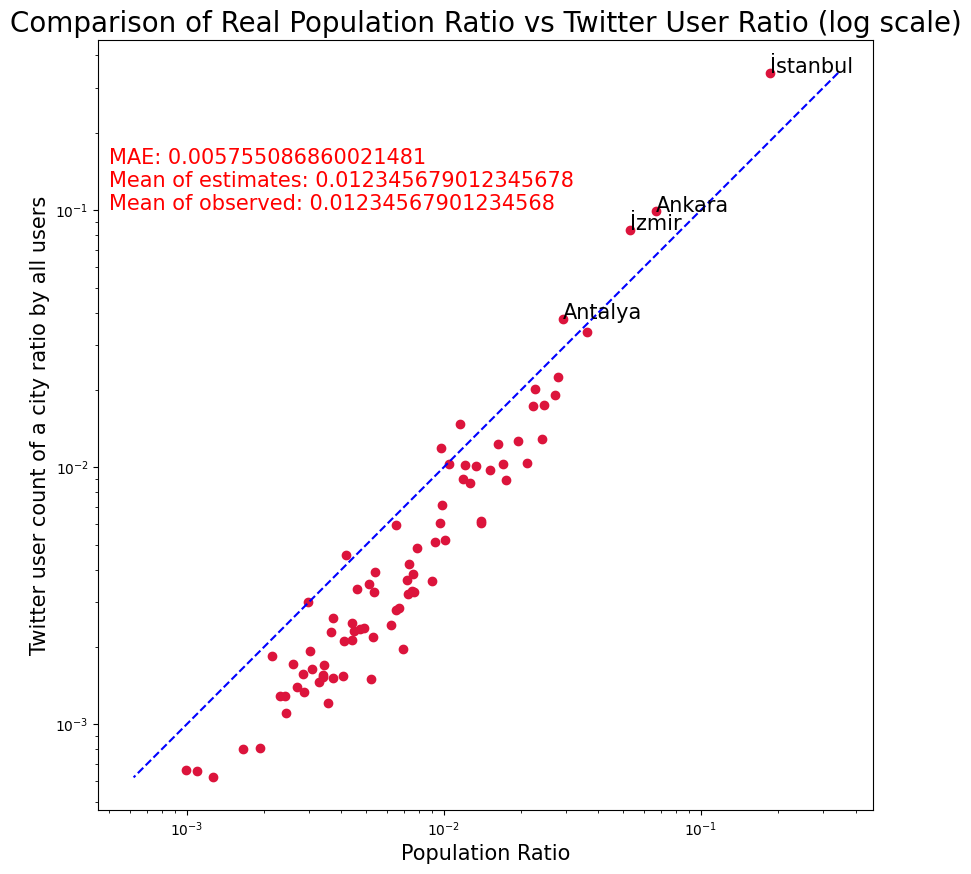

In [44]:
path = "trial_data_gathered/individual/guess/userloc.json"
est_dict = obtain_dict(path)

plot = ratio_vs_ratio(obs_dict, est_dict)
#plot.savefig("graphs/individual/guess_userloc/ratio_vs_ratio")


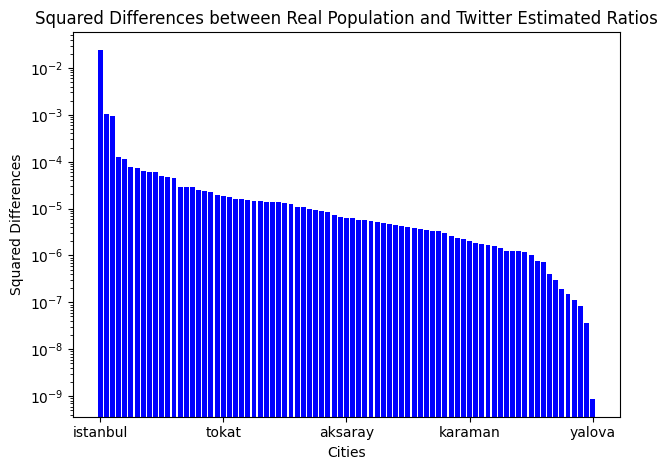

In [9]:
plot = sq_diff_all(obs_dict, est_dict)
plot.savefig("graphs/individual/guess_userloc/sqdiff_all")

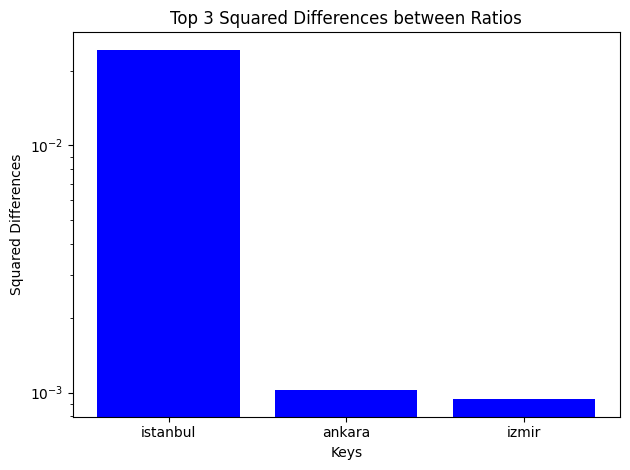

In [11]:
plot = top3(obs_dict, est_dict)
plot.savefig("graphs/individual/guess_userloc/sqdiff_top3")

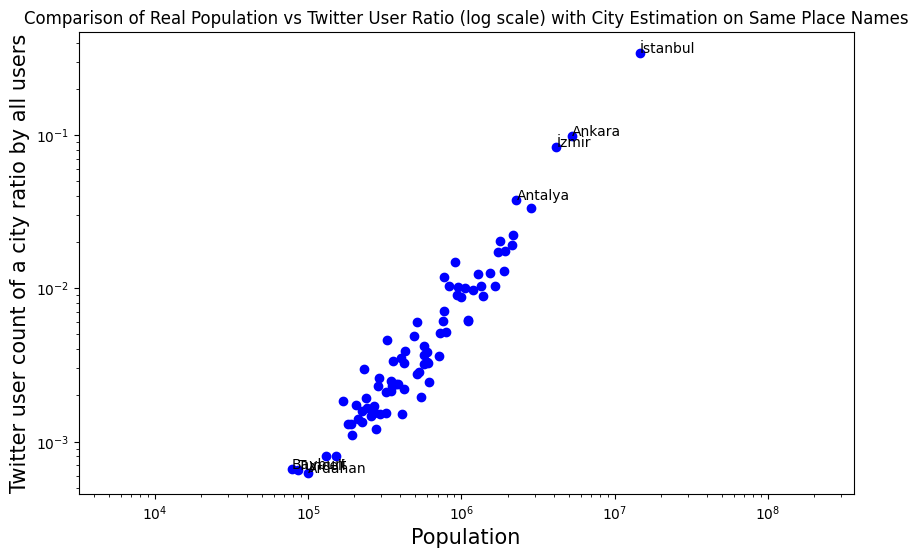

In [61]:
plot = ratio_vs_real(pop_dict, est_dict)
plot.savefig("graphs/individual/guess_userloc/ratio_vs_real")

In [62]:
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################

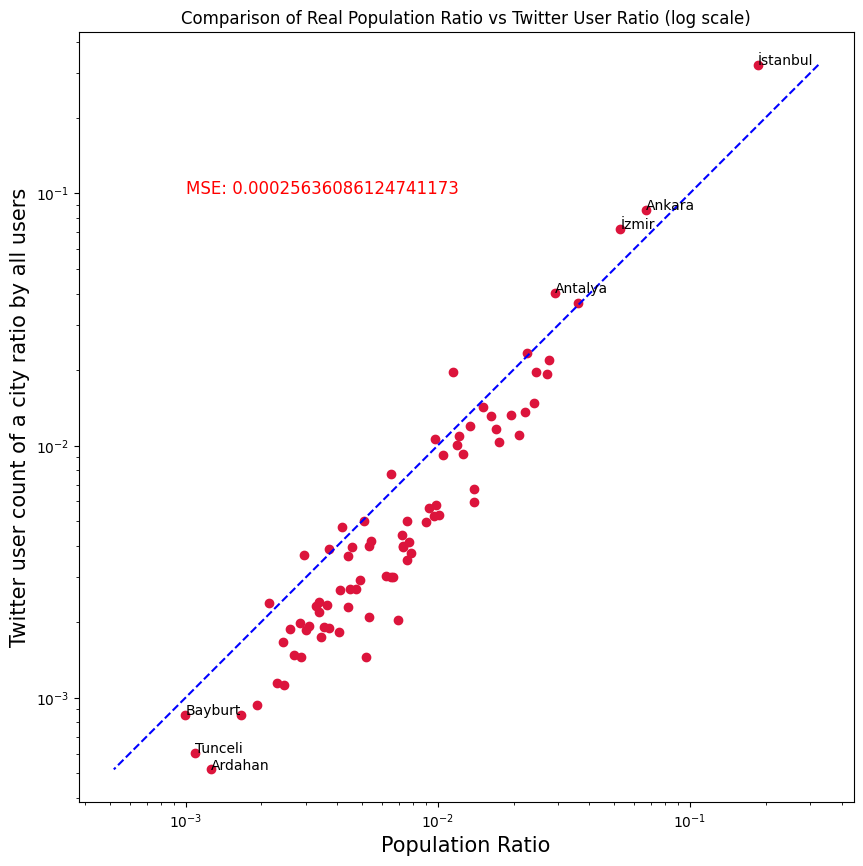

In [63]:
path = "trial_data_gathered/individual/guess/tweetloc.json"
est_dict = obtain_dict(path)

plot = ratio_vs_ratio(obs_dict, est_dict)
plot.savefig("graphs/individual/guess_tweetloc/ratio_vs_ratio")

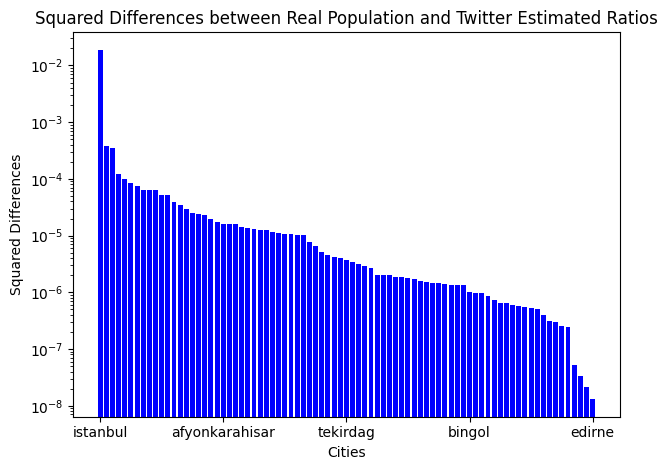

In [64]:
plot = sq_diff_all(obs_dict, est_dict)
plot.savefig("graphs/individual/guess_tweetloc/sqdiff_all")

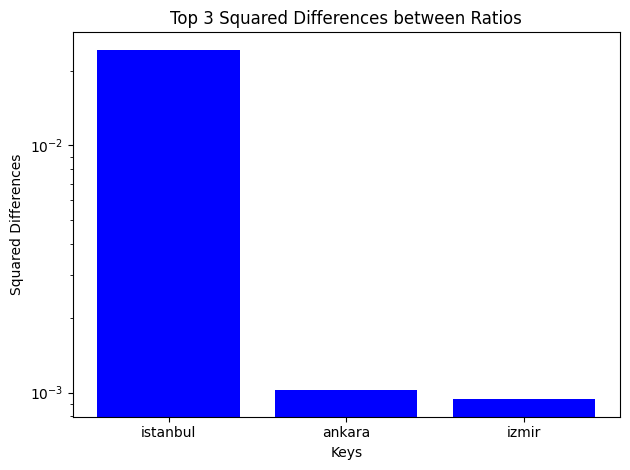

In [74]:
plot = top3(obs_dict, est_dict)
plot.savefig("graphs/individual/guess_tweetloc/sqdiff_top3")

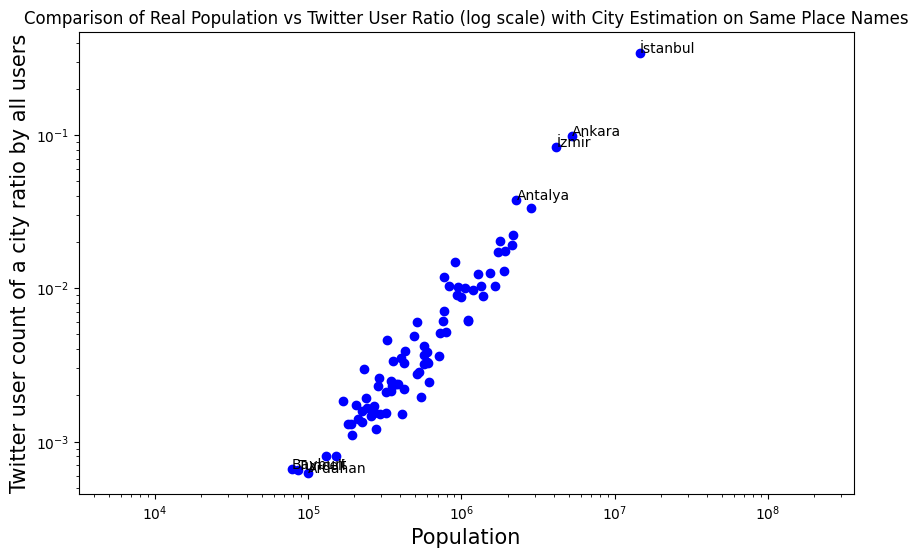

In [75]:
plot = ratio_vs_real(pop_dict, est_dict)
plot.savefig("graphs/individual/guess_tweetloc/ratio_vs_real")

In [ ]:
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################

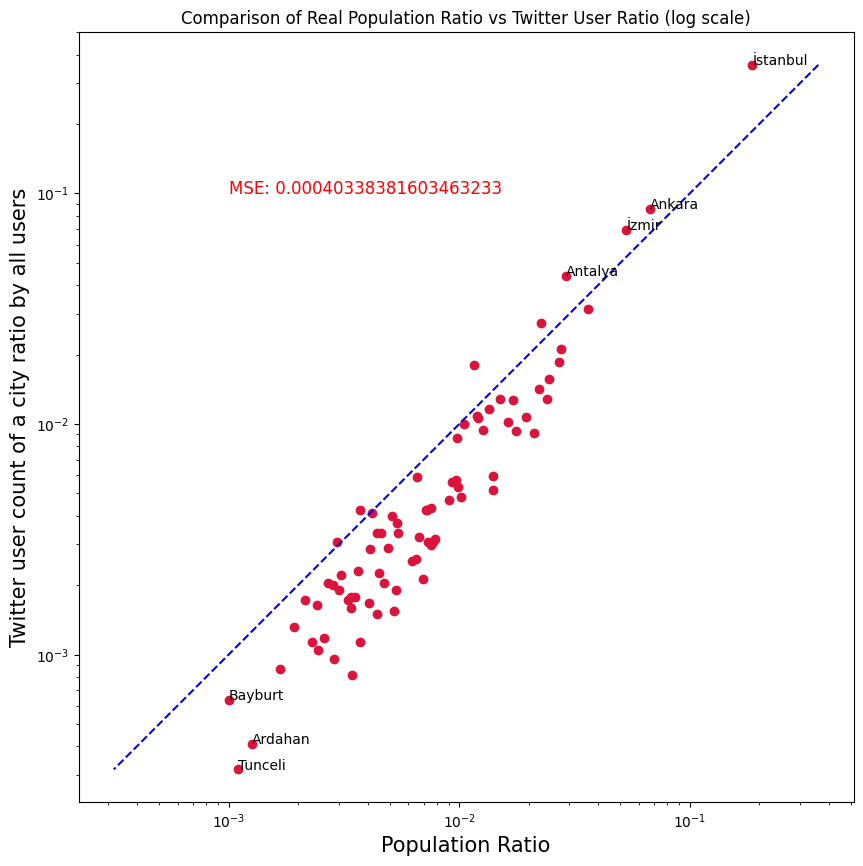

In [77]:
path = "trial_data_gathered/individual/guess/coordinates.json"
est_dict = obtain_dict(path)

plot = ratio_vs_ratio(obs_dict, est_dict)
plot.savefig("graphs/individual/coordinates/ratio_vs_ratio")

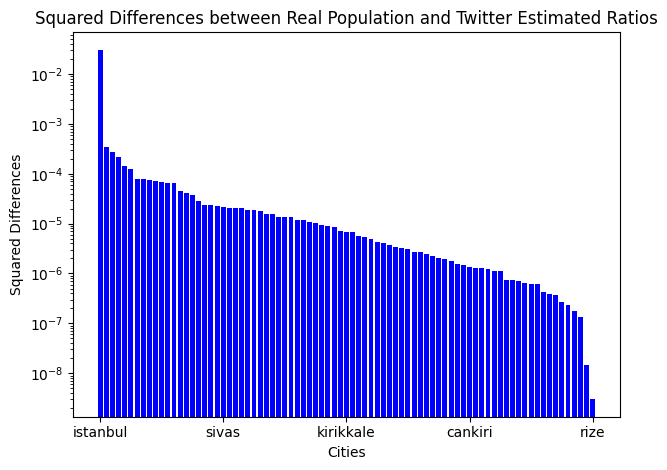

In [78]:
plot = sq_diff_all(obs_dict, est_dict)
plot.savefig("graphs/individual/coordinates/sqdiff_all")

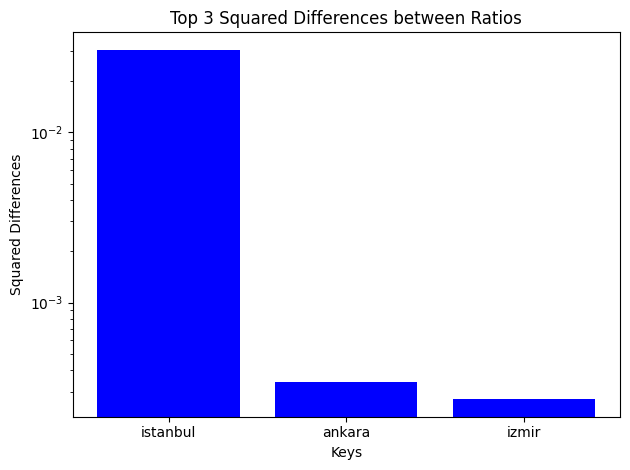

In [79]:
plot = top3(obs_dict, est_dict)
plot.savefig("graphs/individual/coordinates/sqdiff_top3")

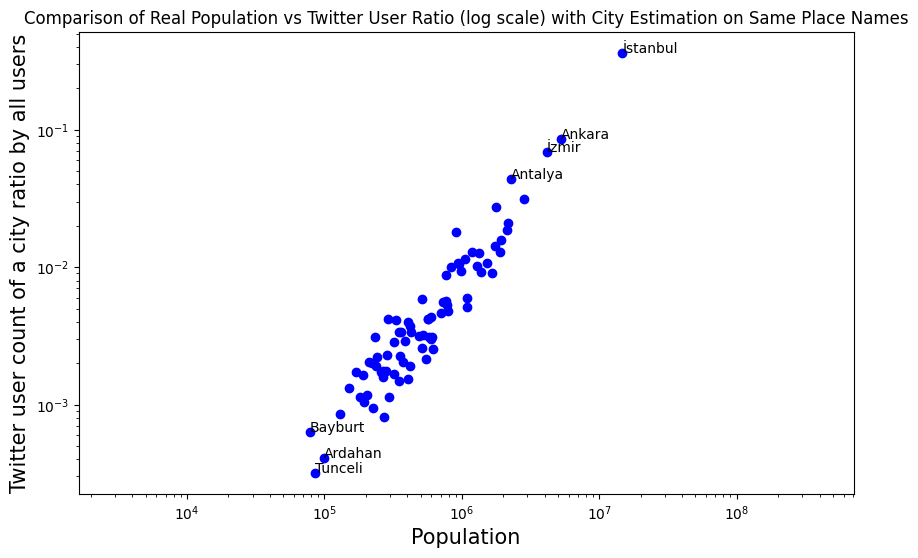

In [80]:
plot = ratio_vs_real(pop_dict, est_dict)
plot.savefig("graphs/individual/coordinates/ratio_vs_real")

In [ ]:
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################

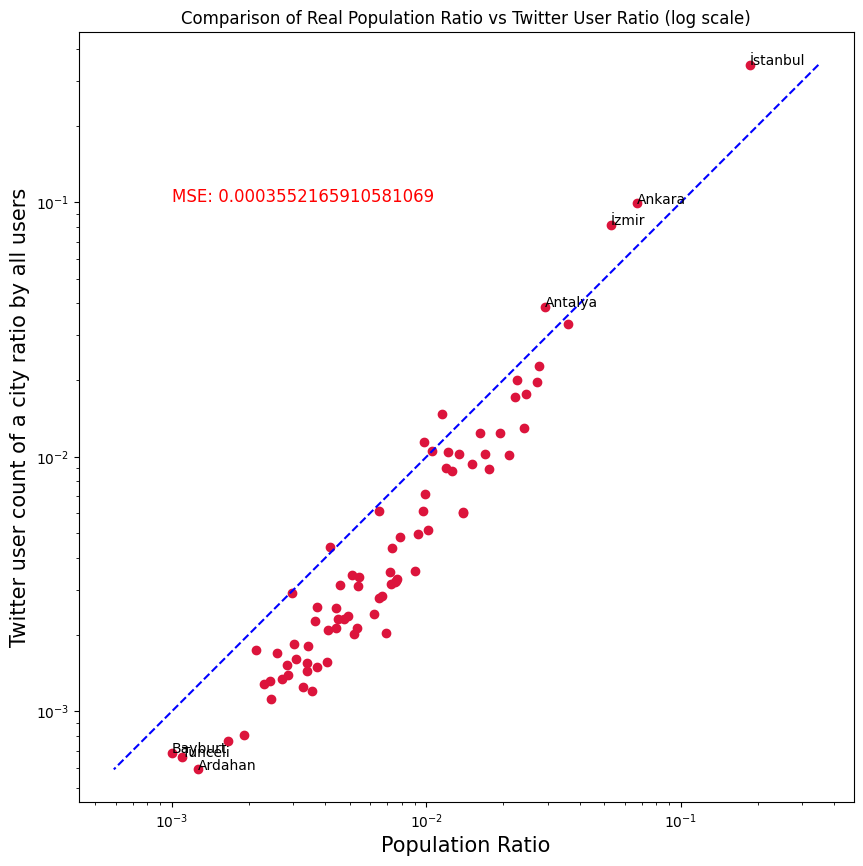

In [81]:
path = "trial_data_gathered/individual/no_guess/userloc.json"
est_dict = obtain_dict(path)

plot = ratio_vs_ratio(obs_dict, est_dict)
plot.savefig("graphs/individual/noguess_userloc/ratio_vs_ratio")

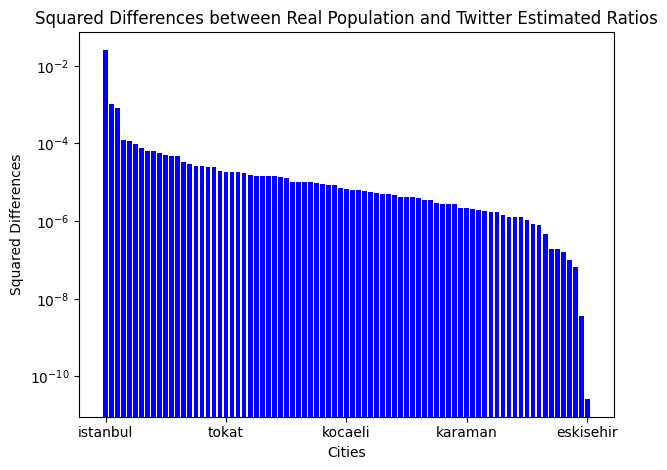

In [82]:
plot = sq_diff_all(obs_dict, est_dict)
plot.savefig("graphs/individual/noguess_userloc/sqdiff_all")

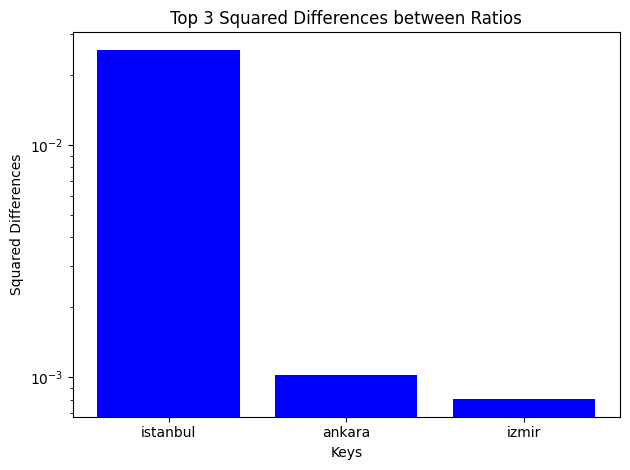

In [83]:
plot = top3(obs_dict, est_dict)
plot.savefig("graphs/individual/noguess_userloc/sqdiff_top3")

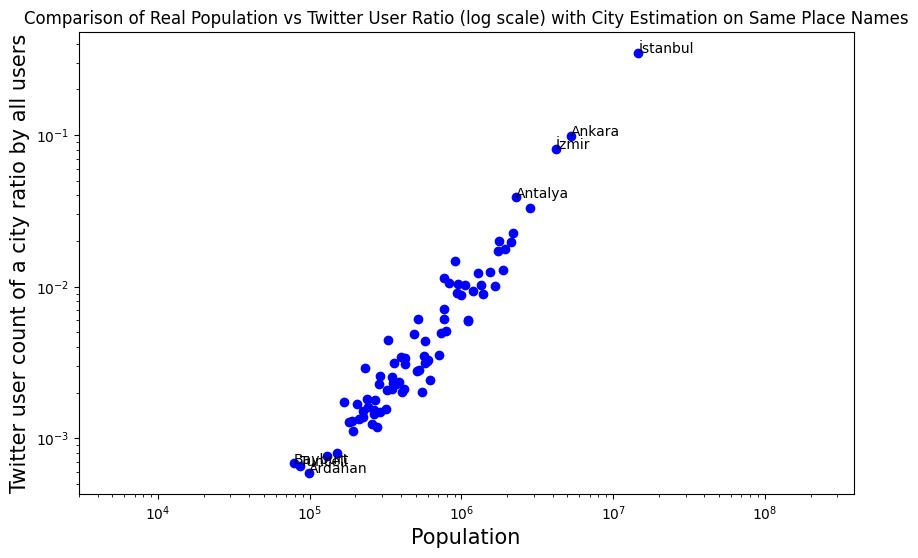

In [84]:
plot = ratio_vs_real(pop_dict, est_dict)
plot.savefig("graphs/individual/noguess_userloc/ratio_vs_real")

In [ ]:
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################

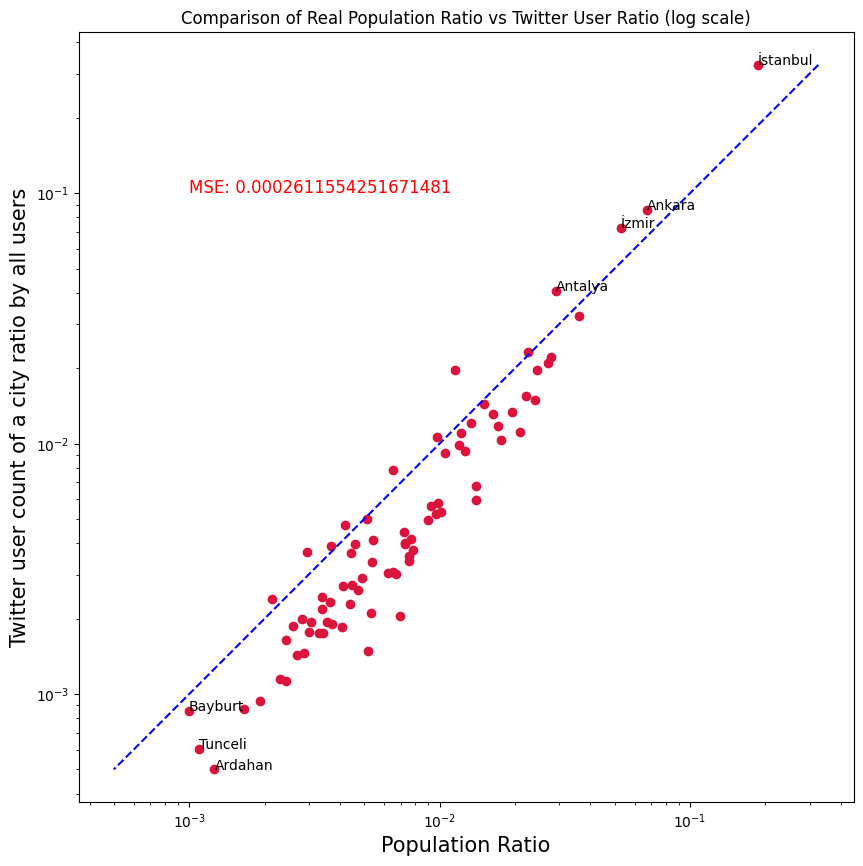

In [85]:
path = "trial_data_gathered/individual/no_guess/tweetloc.json"
est_dict = obtain_dict(path)

plot = ratio_vs_ratio(obs_dict, est_dict)
plot.savefig("graphs/individual/noguess_tweetloc/ratio_vs_ratio")

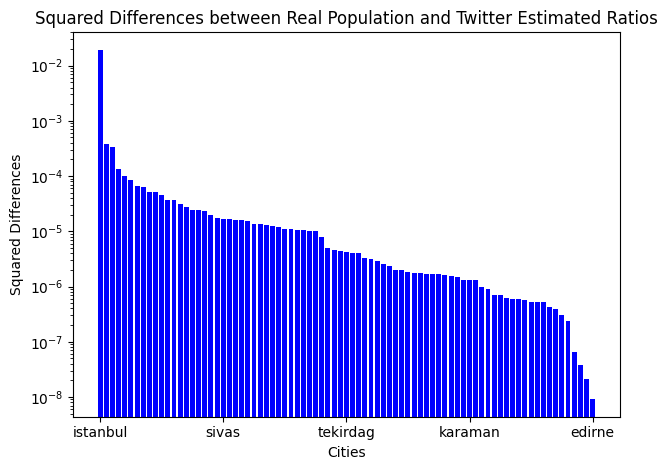

In [86]:
plot = sq_diff_all(obs_dict, est_dict)
plot.savefig("graphs/individual/noguess_tweetloc/sqdiff_all")

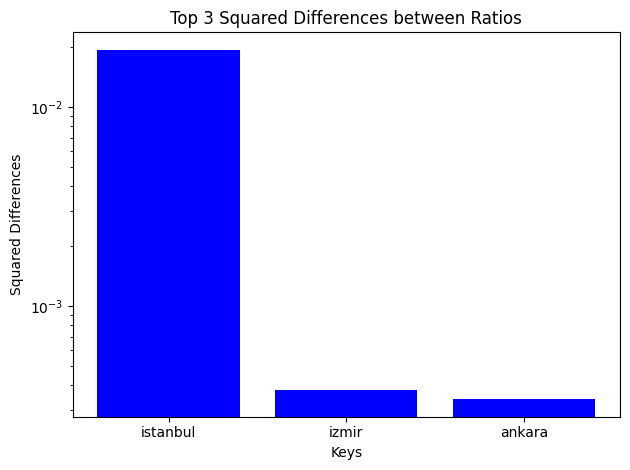

In [87]:
plot = top3(obs_dict, est_dict)
plot.savefig("graphs/individual/noguess_tweetloc/sqdiff_top3")

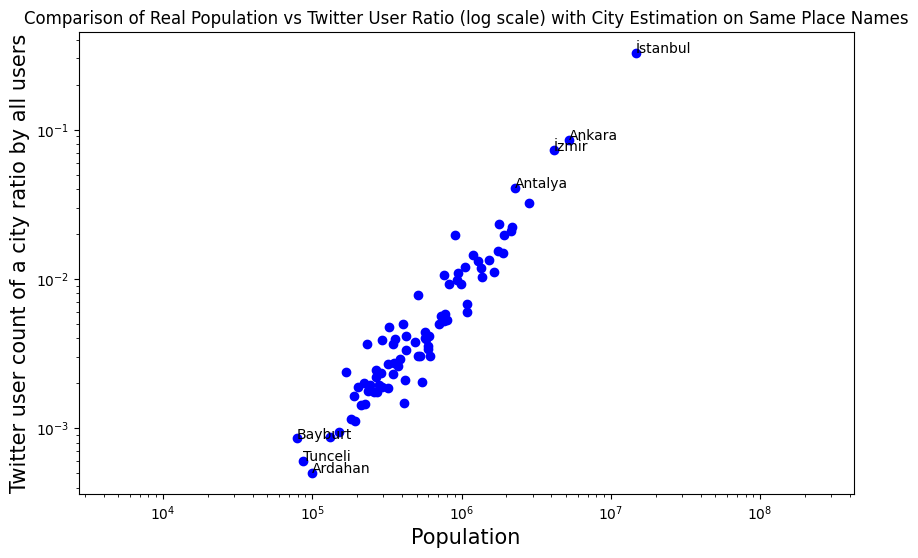

In [88]:
plot = ratio_vs_real(pop_dict, est_dict)
plot.savefig("graphs/individual/noguess_tweetloc/ratio_vs_real")

In [70]:
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################

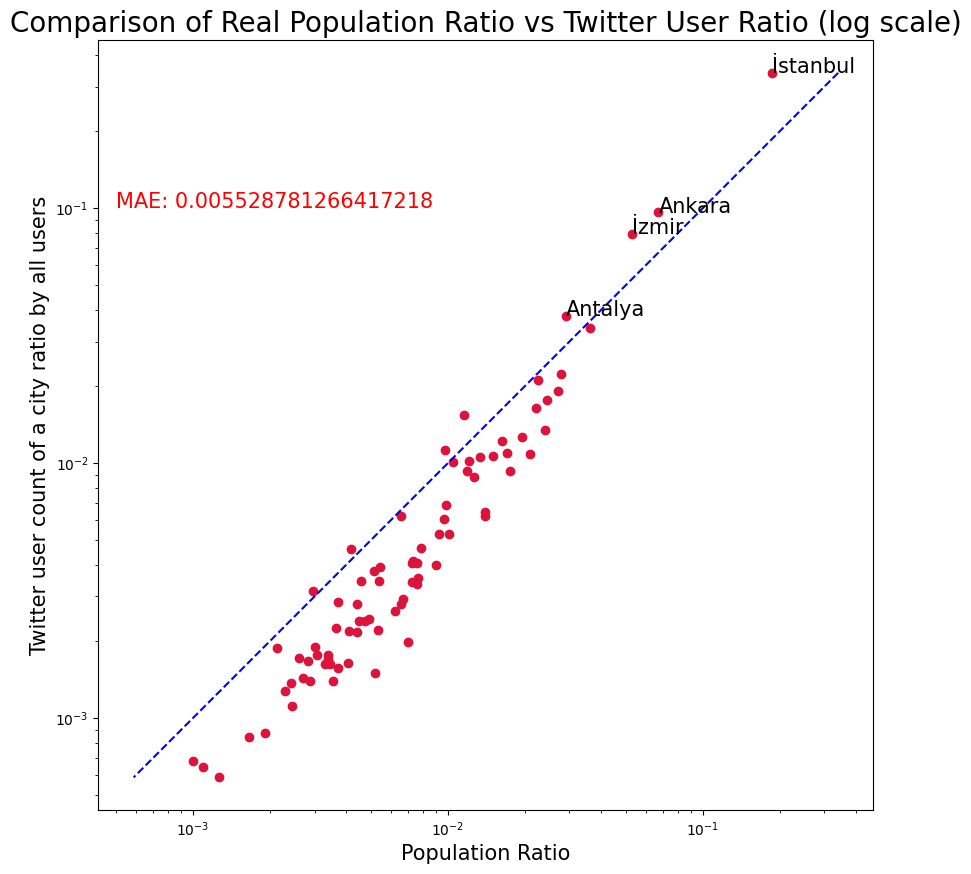

In [6]:
path = "trial_data_gathered/accumulation/guess/3)coordinates.json"
est_dict = obtain_dict(path)

plot = ratio_vs_ratio(obs_dict, est_dict)
#plot.savefig("graphs/accumulation/guess/ratio_vs_ratio")

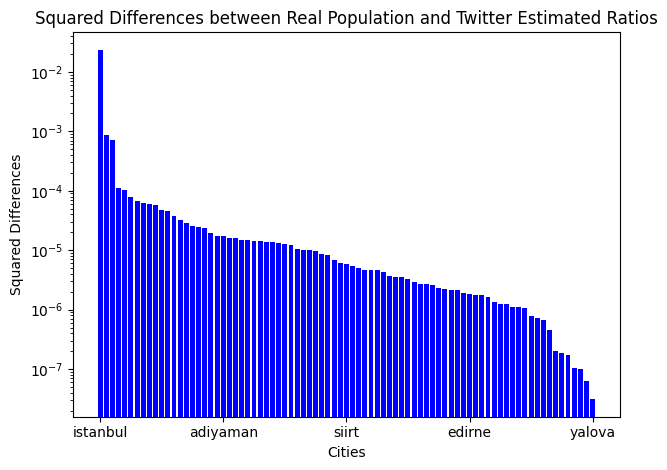

In [90]:
plot = sq_diff_all(obs_dict, est_dict)
plot.savefig("graphs/accumulation/guess/sqdiff_all")

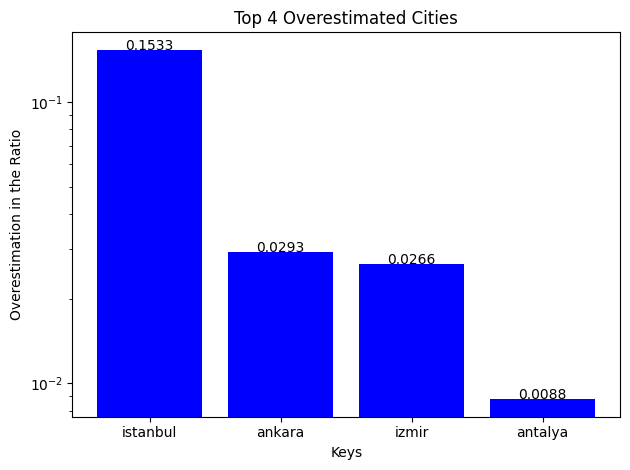

In [86]:
plot = top3(obs_dict, est_dict)
#plot.savefig("graphs/accumulation/guess/sqdiff_top3")

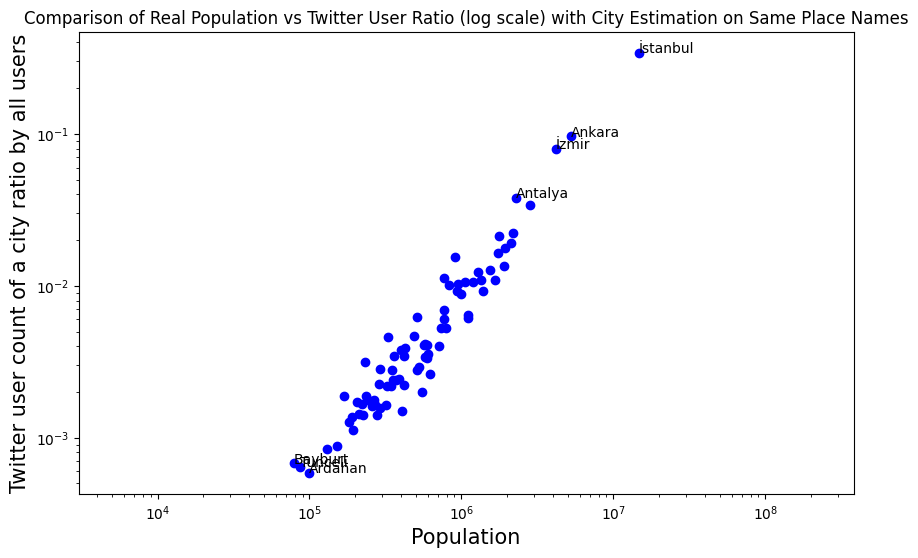

In [92]:
plot = ratio_vs_real(pop_dict, est_dict)
plot.savefig("graphs/accumulation/guess/ratio_vs_real")

In [ ]:
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################
############################################################################################################################

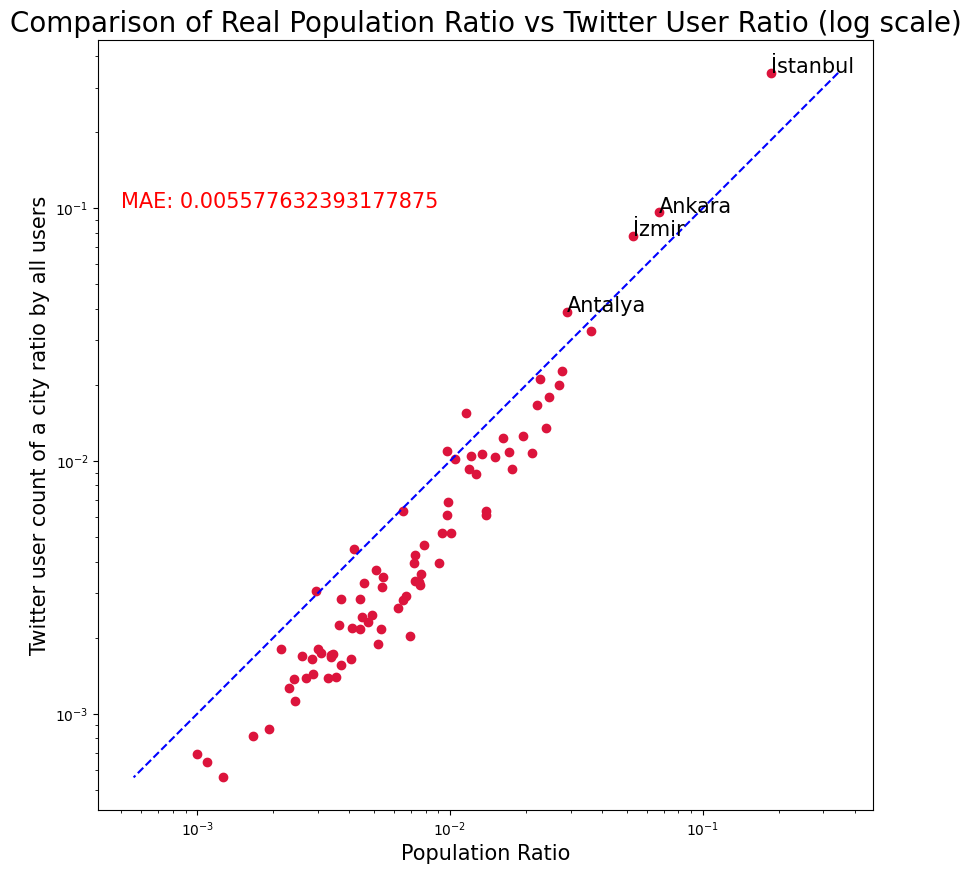

In [57]:
path = "trial_data_gathered/accumulation/no_guess/3)coordinates.json"
est_dict = obtain_dict(path)

plot = ratio_vs_ratio(obs_dict, est_dict)
#plot.savefig("graphs/accumulation/no_guess/ratio_vs_ratio")

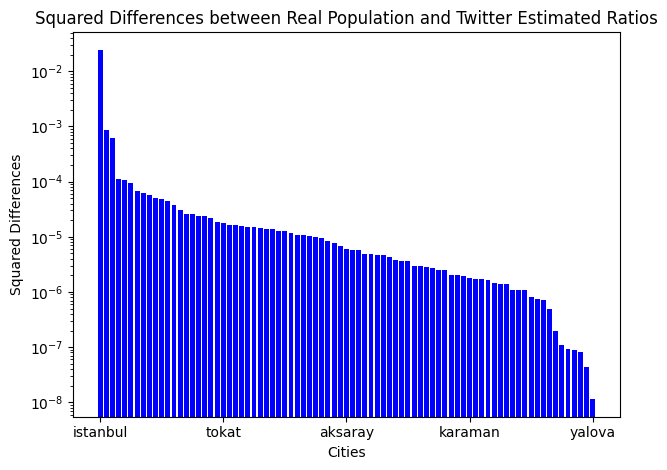

In [94]:
plot = sq_diff_all(obs_dict, est_dict)
plot.savefig("graphs/accumulation/no_guess/sqdiff_all")

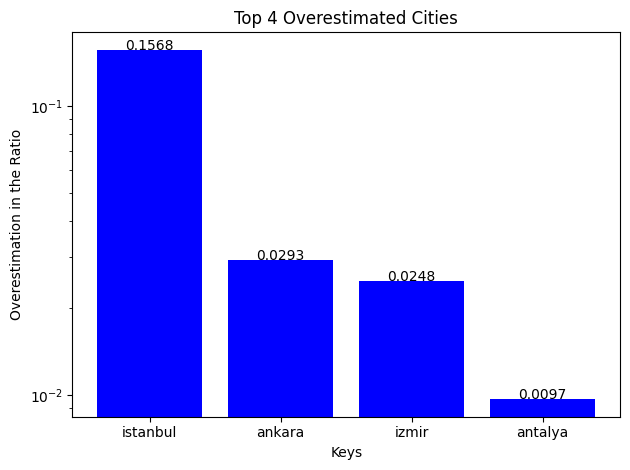

In [84]:
plot = top3(obs_dict, est_dict)
#plot.savefig("graphs/accumulation/no_guess/sqdiff_top3")

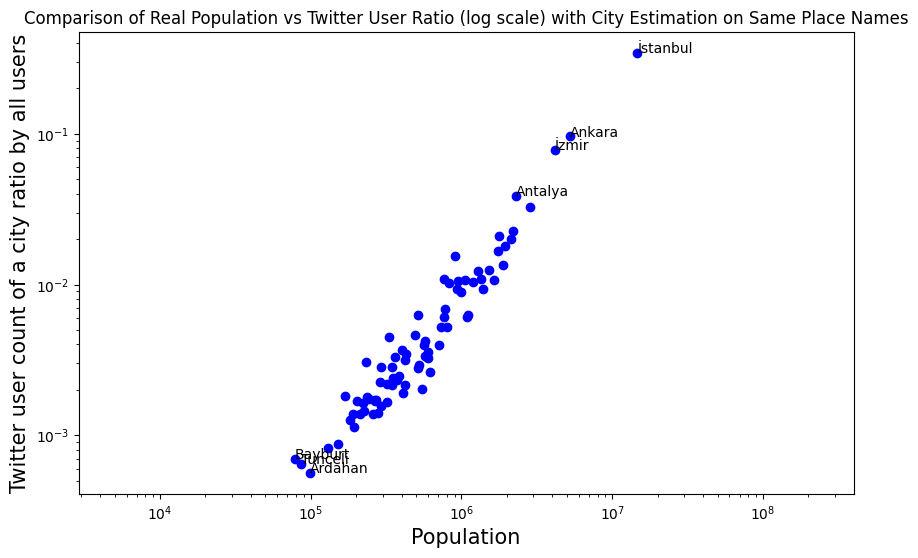

In [96]:
plot = ratio_vs_real(pop_dict, est_dict)
plot.savefig("graphs/accumulation/no_guess/ratio_vs_real")